In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc
from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


# TODO 
- fai l'update della funzione load_res_and_tools per rievere in input anche il parametro ENHN che sono gli ultimi che mi ha mandato dimitris.
- metti i colori giusti ai modelli quando plotto l'AUC

In [11]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
SPECIE_PARIS = 'human'

#ARGS for splash, ricseq, mario
only_test = False
exclude_train_genes = False
exclude_paris_genes = False
exclude_paris_couples = True
filter_hq_ricseq = False
MIN_N_READS_RICSEQ = 3

In [12]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0060') 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

DATASET: paris


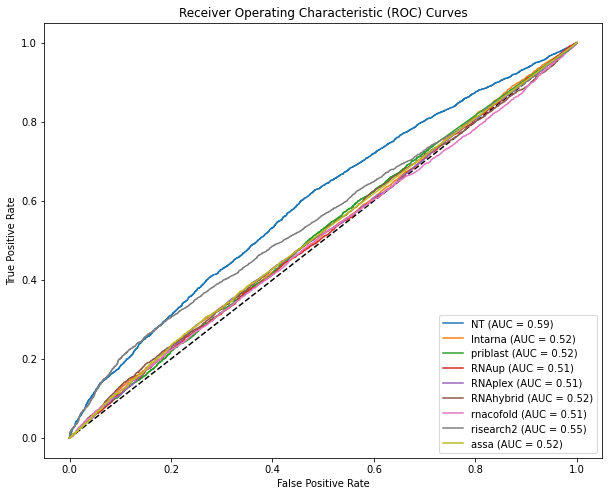

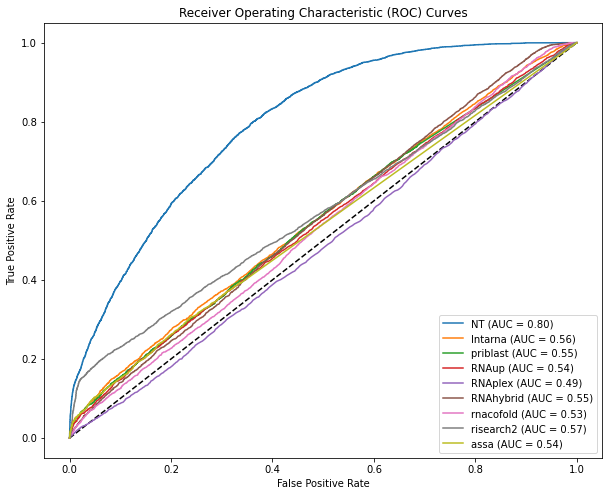




# excluded couples:  234
DATASET: ricseq


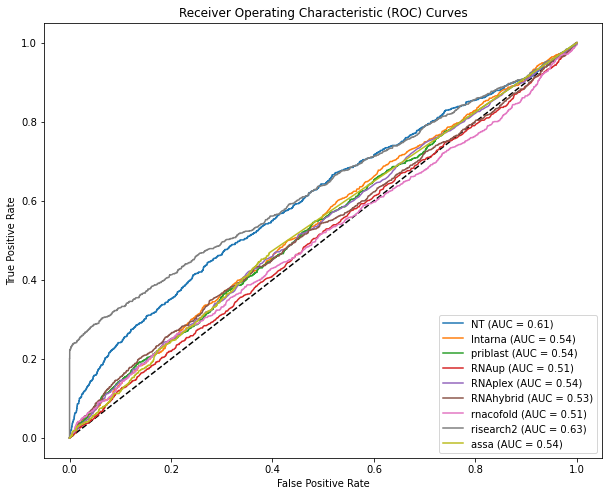

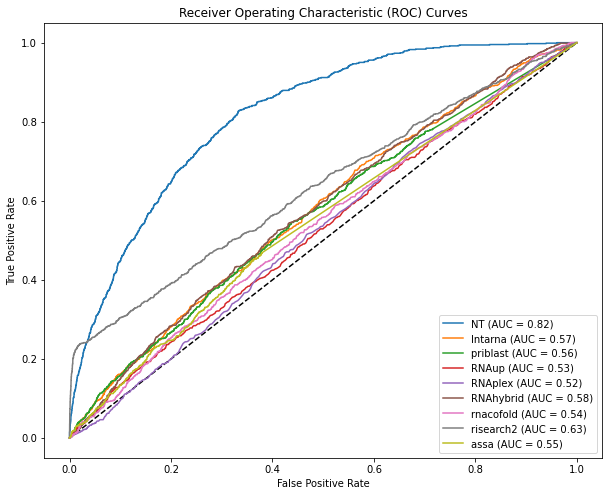




# excluded couples:  56
DATASET: splash


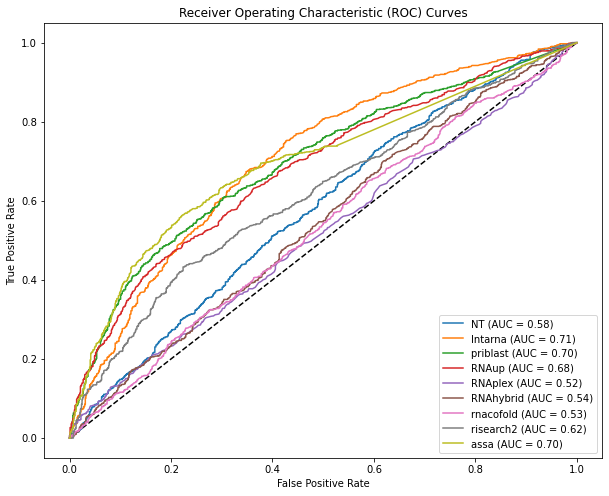

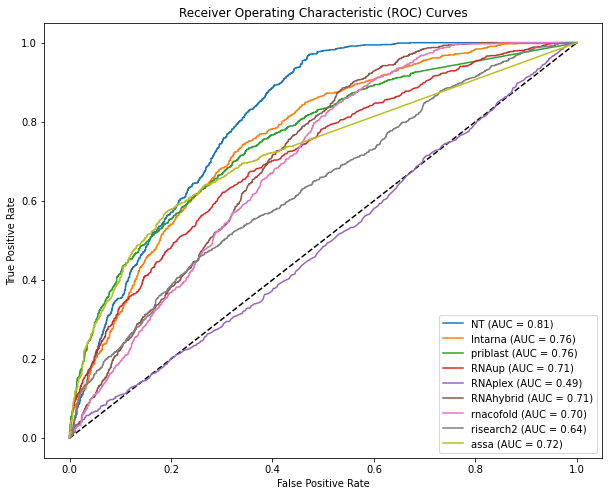




# excluded couples:  4
DATASET: mario


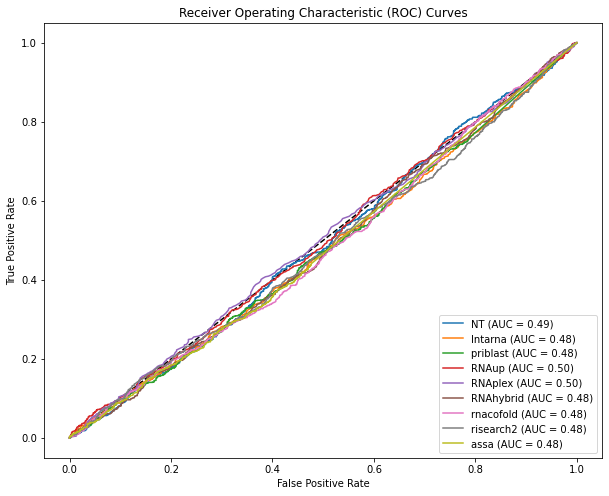

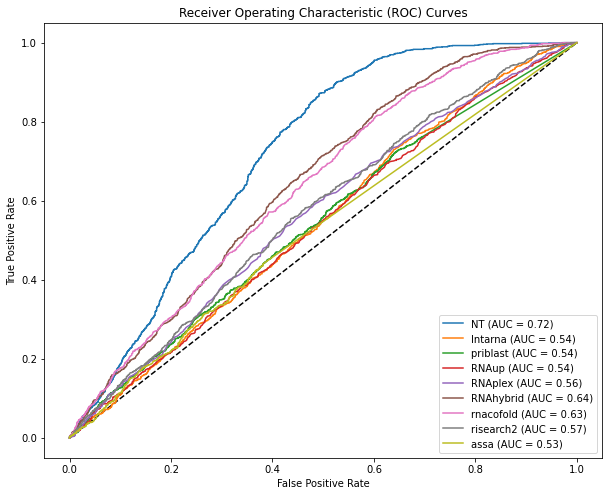

In [13]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))
    
    print(f'DATASET: {dataset}')
    plot_all_model_auc(easypos_smartneg, tools)
    plot_all_model_auc(ephnen, tools)
    print('\n\n')
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

ricseq


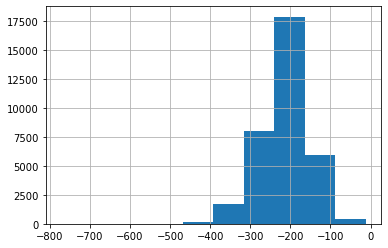

In [14]:
tool_name = 'RNAhybrid' #RNAhybrid
for how in ['ricseq']: #['ricseq', 'mario', 'test', 'splash']
    tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
    tool['value'] = tool['value'].astype(float)
    print(how)
    tool.value.hist()
    plt.show()
    print('\n')

# Map models signal in [0, 1] and save the mapping

##### Train the model (we train with paris)

In [7]:
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, 'test', how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
easypos_smartneg = balance_df(easypos_smartneg)


ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
ephnen = balance_df(ephnen)

# excluded couples:  234


In [8]:
df_training = res.copy()
n_hardneg_easyneg_to_sample = df_training[df_training.policy == 'smartneg'].shape[0]
easyneg_hardneg_training = df_training[df_training.policy.isin(['hardneg', 'easyneg'])]
easyneg_hardneg_training = easyneg_hardneg_training.sample(n_hardneg_easyneg_to_sample)
df_training = pd.concat([
    df_training[df_training.policy.isin(['smartneg', 'easypos'])],
    easyneg_hardneg_training
], axis = 0).reset_index(drop = True)

In [9]:
logistic_regression_models = {}
for model_column in tqdm(energy_columns):
    
    
    df_s = df_training.copy()
    df_s = remove_outliers(df_s, model_column)
    df_s = balance_df(df_s)
    
    X_train, y_train = np.expand_dims(df_s[model_column], 1), np.array(df_s.ground_truth)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Calculate threshold_value
    threshold_value = -model.intercept_ / model.coef_
    threshold_value = np.round(threshold_value[0][0], 2)

    logistic_regression_models[model_column] = {'intercept': model.intercept_[0], 
                                               'coef': model.coef_[0][0],
                                               'threshold_value': threshold_value}

  0%|          | 0/8 [00:00<?, ?it/s]

### Test and plot 

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy: 0.54
Threshold value: -8.03


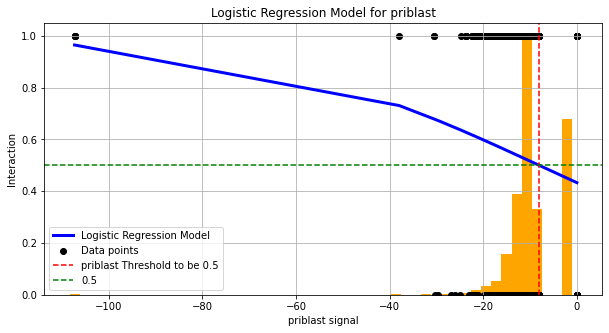

Accuracy: 0.507
Threshold value: -9.65


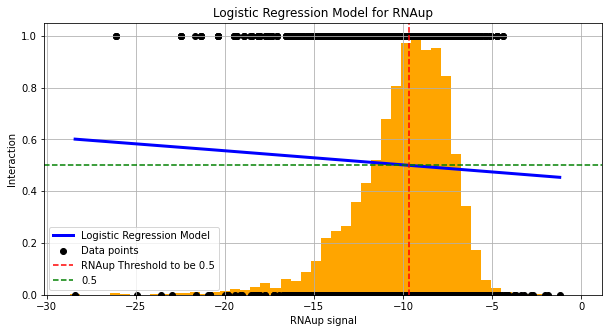

Accuracy: 0.5144
Threshold value: -33.64


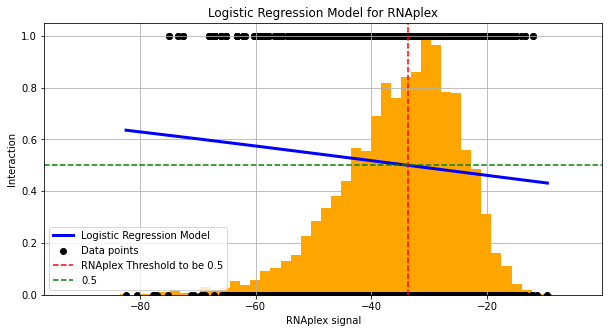

Accuracy: 0.561
Threshold value: -217.79


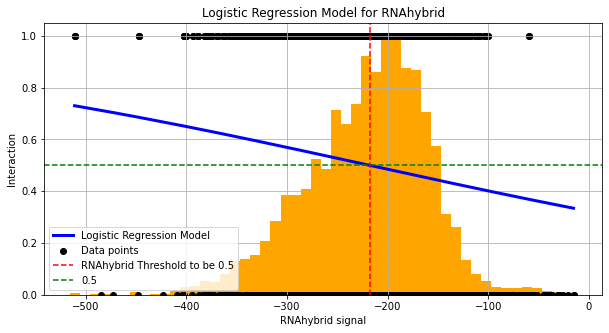

Accuracy: 0.5308
Threshold value: -321.5


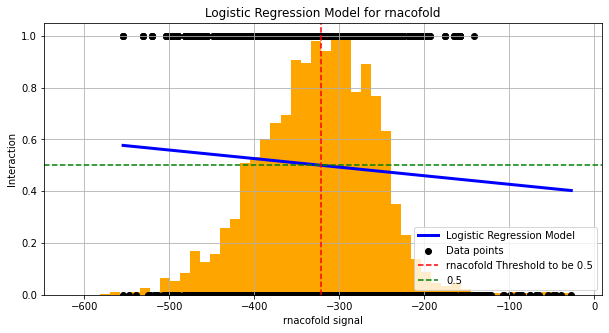

Accuracy: 0.5904
Threshold value: -42.3


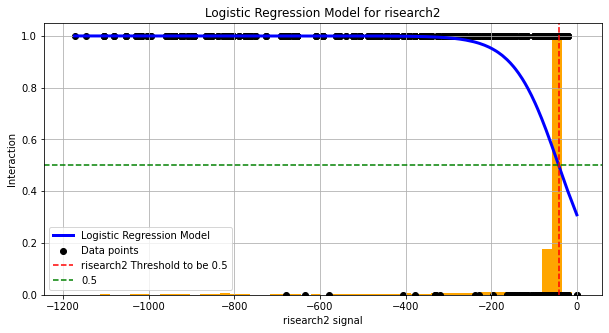

Accuracy: 0.5422
Threshold value: -5.84


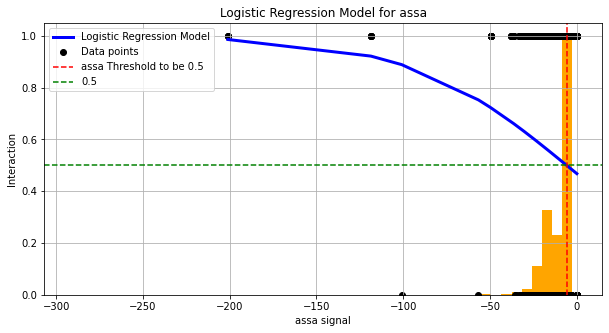

Accuracy: 0.5426
Threshold value: -1.21


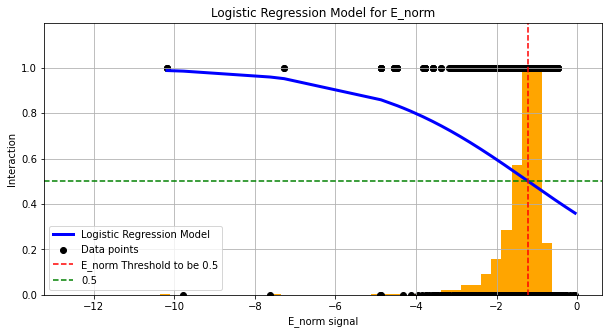

In [11]:
how = 'patches'

N_SAMPLES_TEST = 5000


plt.rcParams['figure.figsize'] = [10, 5]

for model_column in tqdm(energy_columns):
    if how == 'interactors':
        df_test = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True).copy()
    elif how == 'patches':
        df_test =res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True).copy()
      
    df_test = balance_df(df_test)
    
    sample_test = df_test.sample(N_SAMPLES_TEST)
    X_test, y_test = np.expand_dims(sample_test[model_column], 1), np.expand_dims(sample_test.ground_truth, 1)

    lrm_dict = logistic_regression_models[model_column]
    y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
    accuracy = accuracy_score(y_test, (y_pred>0.5).astype(int))
    
    print("Accuracy:", accuracy)

    threshold_value = lrm_dict['threshold_value']
    print("Threshold value:", threshold_value)


    #Plot model and predictions
    plot_histogram_01(df_test[model_column])
    plt.plot(np.sort(X_test, axis=0), 
             log_func(lrm_dict['intercept'], lrm_dict['coef'], np.sort(X_test, axis=0))[:, 0], 
             color='blue', linewidth=3, label='Logistic Regression Model')
    plt.scatter(X_test, y_test, color='black', label='Data points')    
    plt.axvline(x=threshold_value, color='r', linestyle='--', label=f'{model_column} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')


    plt.xlabel(f'{model_column} signal')
    plt.ylabel('Interaction')
    plt.grid()
    plt.title(f'Logistic Regression Model for {model_column}')
    plt.legend()
    plt.show()

DATASET: paris


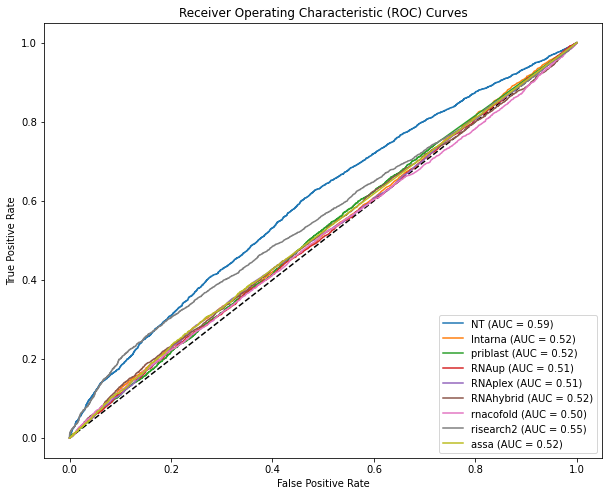

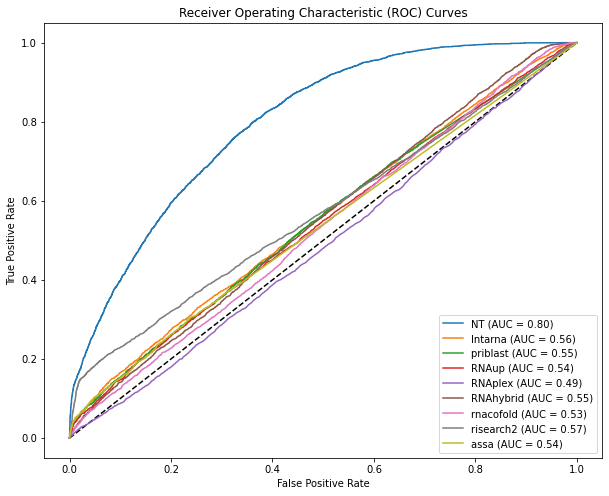




# excluded couples:  234
DATASET: ricseq


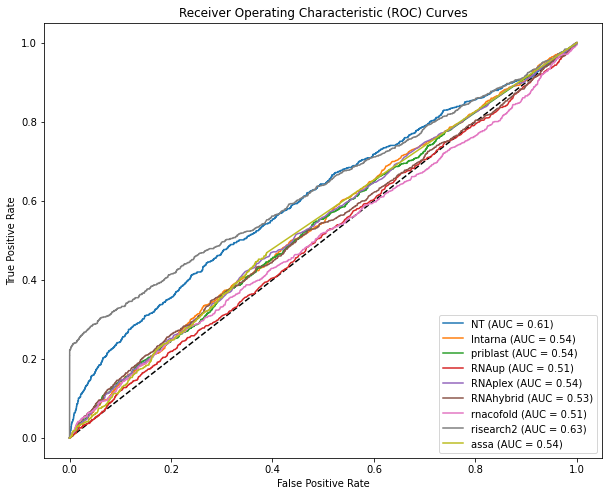

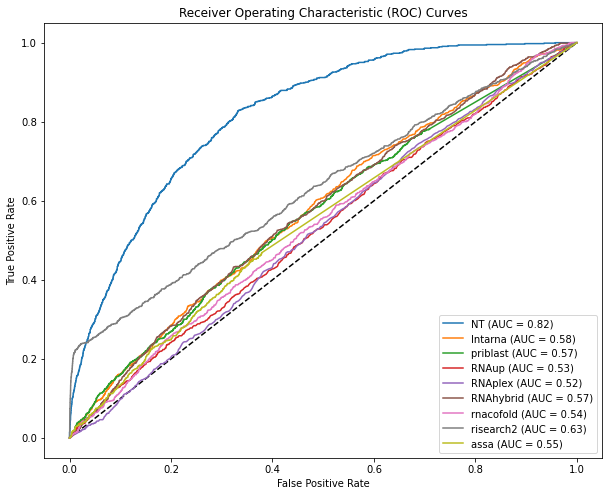




# excluded couples:  56
DATASET: splash


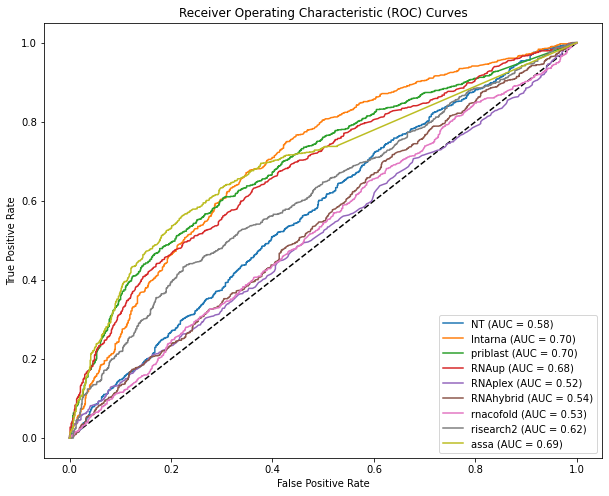

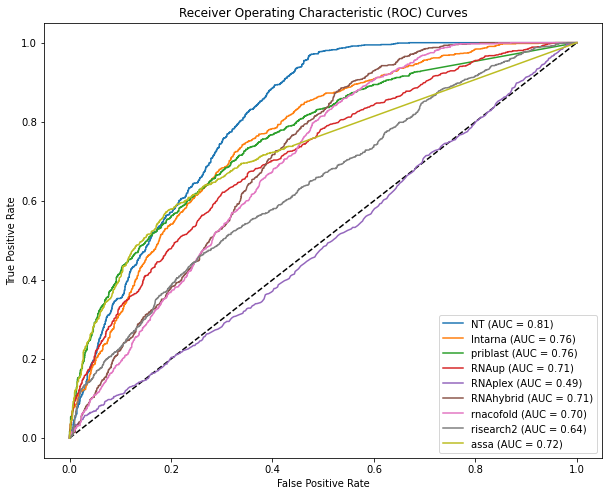




# excluded couples:  4
DATASET: mario


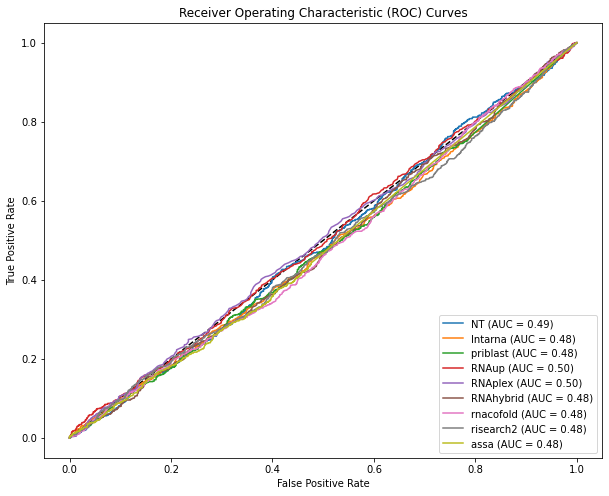

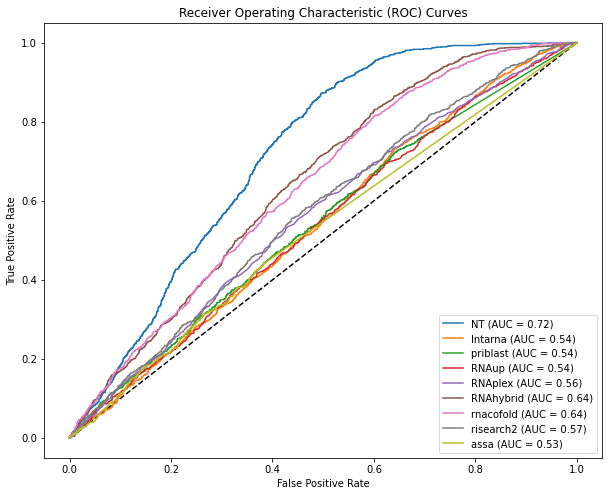

In [12]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
    
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
    
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    
    
    m = obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1)
    m['model_name'] = m['model_name'] + '_logistic'
    dfs.append(m)
    
    m = obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1)
    m['model_name'] = m['model_name'] + '_logistic'
    dfs.append(m)
    
    
    print(f'DATASET: {dataset}')
    plot_all_model_auc(easypos_smartneg, tools)
    plot_all_model_auc(ephnen, tools)
    print('\n\n')

In [13]:
df_auc2 = pd.concat(dfs, axis = 1)
df_auc2 = df_auc2.loc[:,~df_auc2.columns.duplicated()].copy()

In [14]:
errors = df_auc.drop('model_name', axis =1 ) - df_auc2.drop('model_name', axis =1 )

In [15]:
errors['model_name'] = df_auc['model_name']

In [16]:
errors

,auc_EPSN_paris,auc_EPENHN_paris,auc_EPSN_ricseq,auc_EPENHN_ricseq,auc_EPSN_splash,auc_EPENHN_splash,auc_EPSN_mario,auc_EPENHN_mario,model_name
0,0.00,0.0,-0.01,0.00,-0.01,0.00,0.0,0.00,NT
1,0.00,0.0,0.00,0.00,0.01,0.00,0.0,0.00,INTARNA
2,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,priblast
3,0.00,0.0,-0.01,0.00,0.00,0.00,0.0,0.00,RNAup
4,0.00,0.0,0.00,0.01,0.00,0.01,0.0,0.00,RNAplex
5,0.00,0.0,0.00,0.01,0.00,0.00,0.0,0.00,RNAhybrid
6,0.01,0.0,0.00,0.00,0.00,0.00,0.0,-0.01,rnacofold
7,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,risearch2
8,0.00,0.0,0.00,0.00,0.01,0.00,0.0,0.00,assa


In [17]:
# Open the file in binary write mode and serialize the dictionary
with open(LR_MAPPING_PATH, 'wb') as file:
    pickle.dump(logistic_regression_models, file)

# Model comparison

In [7]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

In [15]:
for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
    
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping

# excluded couples:  234
# excluded couples:  56
# excluded couples:  4


### STO COSTRUENDO plot_all_model_metrics_based_on_treshold_confidence IN PLOT_UTILS

In [16]:
res

,Unnamed: 0,couples,gene1_pc,gene2_pc,original_length1,original_length2,id_sample,probability,ground_truth,g1,...,original_area,E_norm_conf,ensemble_score,priblast,RNAup,RNAplex,RNAhybrid,rnacofold,risearch2,assa
0,0,ENSMUSG00000033860_ENSMUSG00000039298,True,True,1741,11847,4337,0.497677,0,ENSMUSG00000033860_0_1741,...,20625627,0.233903,0.365790,0.522085,0.501252,0.493873,0.440992,0.479104,0.464893,0.468076
1,1,ENSMUSG00000033860_ENSMUSG00000039298,True,True,1741,11847,4336,0.521076,1,ENSMUSG00000033860_0_1741,...,20625627,0.273440,0.397258,0.509215,0.498018,0.501018,0.494825,0.494188,0.473082,0.468076
2,2,ENSMUSG00000033860_ENSMUSG00000068922,True,True,1741,2093,2263,0.516178,0,ENSMUSG00000033860_0_1741,...,3643913,0.550794,0.533486,0.512482,0.495442,0.467619,0.483957,0.492686,0.488930,0.508942
3,3,ENSMUSG00000033860_ENSMUSG00000068922,True,True,1741,2093,2262,0.519469,0,ENSMUSG00000033860_0_1741,...,3643913,0.334567,0.427018,0.514341,0.486948,0.502734,0.490324,0.493353,0.470287,0.468076
4,4,ENSMUSG00000027799_ENSMUSG00000039298,True,True,10986,11847,4619,0.449181,0,ENSMUSG00000027799_3357_9326,...,130151142,0.801326,0.625253,0.520811,0.503555,0.513307,0.522246,0.499165,0.484134,0.553427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,4600,ENSMUSG00000021578_ENSMUSG00000024590,True,True,9559,2843,4006,0.425607,0,ENSMUSG00000021578_236_6206,...,27176237,0.256524,0.341066,0.433297,0.503335,0.495016,0.478198,0.512522,0.469435,0.468076
4597,4601,ENSMUSG00000016756_ENSMUSG00000046402,True,True,9789,2652,3931,0.574926,0,ENSMUSG00000016756_484_6453,...,25960428,1.000000,0.787463,0.803844,0.647884,0.495302,0.536551,0.514558,0.757977,0.846988
4598,4602,ENSMUSG00000016756_ENSMUSG00000046402,True,True,9789,2652,3930,0.471167,0,ENSMUSG00000016756_1679_7649,...,25960428,0.151790,0.311479,0.511456,0.506405,0.464205,0.430633,0.483806,0.454507,0.468076
4599,4603,ENSMUSG00000033826_ENSMUSG00000042502,True,True,16685,3284,4334,0.498826,0,ENSMUSG00000033826_99_6069,...,54793540,0.329572,0.414199,0.519811,0.491441,0.509021,0.550291,0.525761,0.546247,0.468076


In [13]:
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, 'test', how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
easypos_smartneg = balance_df(easypos_smartneg)


ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
ephnen = balance_df(ephnen)

# excluded couples:  56


In [14]:
def evaluate_threshold(df, model_column, threshold):
    mapped_signal = map_signal_to_sigmoid_range(df[model_column], threshold)
    mapped_signal = 1 - mapped_signal  # Invert for interpretation
    accuracy_gt_1 = ((mapped_signal < 0.5) & (df['ground_truth'] == 0)).mean()
    accuracy_lt_0 = ((mapped_signal >= 0.5) & (df['ground_truth'] == 1)).mean()
    total_accuracy = (accuracy_gt_1 + accuracy_lt_0) / 2  # Average accuracy
    return total_accuracy

In [15]:
df_s = easypos_smartneg.copy() 
#df_s = ephnen.copy()  

energy_columns = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa', 'E_norm']

best_thresholds = {}
for model_column in tqdm(energy_columns):
    best_accuracy = -1
    best_threshold = None
    min_treshold = df_s[model_column].mean() - (2 * df_s['assa'].std())
    max_treshold = df_s[model_column].mean() + (2 * df_s['assa'].std())
    max_treshold = min(0, max_treshold)
    # Define the range of potential threshold values
    potential_thresholds = np.linspace(min_treshold, max_treshold, 1_000)
    
    for threshold in potential_thresholds:
        accuracy = evaluate_threshold(df_s, model_column, threshold)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    best_thresholds[model_column] = best_threshold

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
def custom_sigmoid(x, slope_at_origin=2):
    return 0.5 + 0.5 * np.tanh(x * slope_at_origin)

def map_signal_to_sigmoid_range(signal, threshold, slope_at_origin = 2):
    mapped_signal = custom_sigmoid((signal - threshold), slope_at_origin = slope_at_origin)
    return mapped_signal

def plot_histogram_01(data, bins = 50):

    # Plot histogram
    n, bins, patches = plt.hist(data, density=True, bins=bins, alpha=0)  # Plot without displaying

    # Get the maximum value in the histogram
    max_density = max(n)

    # Scale the y-values
    n_scaled = [val / max_density for val in n]

    # Plot the scaled histogram
    plt.bar(bins[:-1], n_scaled, width=bins[1]-bins[0], color = 'orange')


In [108]:
logistic_regression_models

{'priblast': {'intercept': -1.3729273603119811,
  'coef': -0.13055111465860883,
  'threshold_value': -10.52},
 'RNAup': {'intercept': -2.341296324685742,
  'coef': -0.21942916759378597,
  'threshold_value': -10.67},
 'RNAplex': {'intercept': -0.24903541088269093,
  'coef': -0.006645756105272504,
  'threshold_value': -37.47},
 'RNAhybrid': {'intercept': -0.75438522457696,
  'coef': -0.0031159363588686754,
  'threshold_value': -242.11},
 'rnacofold': {'intercept': -0.6501092692929774,
  'coef': -0.0018752864445753833,
  'threshold_value': -346.67},
 'risearch2': {'intercept': -1.7936333925752106,
  'coef': -0.04051979821861928,
  'threshold_value': -44.27},
 'assa': {'intercept': -0.775193436517752,
  'coef': -0.07405544876174112,
  'threshold_value': -10.47},
 'E_norm': {'intercept': -1.716455777935475,
  'coef': -1.2058447675680437,
  'threshold_value': -1.42}}

In [18]:
best_thresholds

{'priblast': -10.663736035234816,
 'RNAup': -11.763679926847502,
 'RNAplex': -50.284463224637825,
 'RNAhybrid': -218.89743005947864,
 'rnacofold': -328.28183975767047,
 'risearch2': -46.44063492593665,
 'assa': -14.423598985990882,
 'E_norm': -1.301451154072943}

In [19]:
slope_at_the_origins = {
    'priblast':0.1,
    'RNAup':0.5, 
    'RNAplex':0.1, 
    'RNAhybrid':0.03,
    'rnacofold':0.02,
    'risearch2':0.1, 
    'assa':0.2,
    'E_norm':2,
}

------- priblast -------


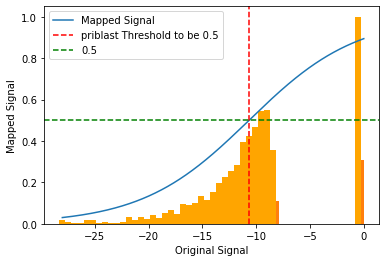

------- RNAup -------


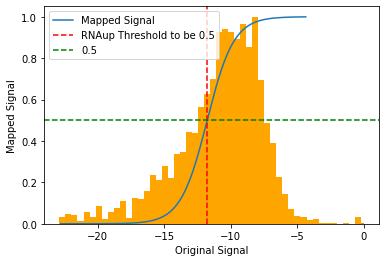

------- RNAplex -------


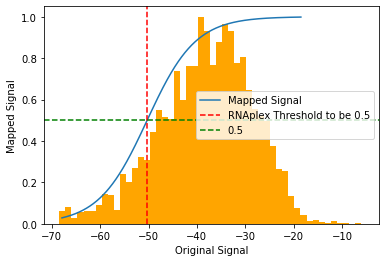

------- RNAhybrid -------


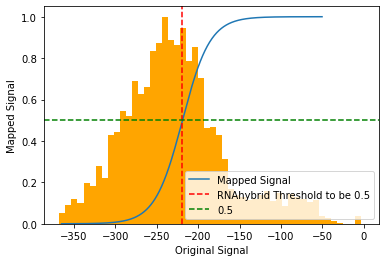

------- rnacofold -------


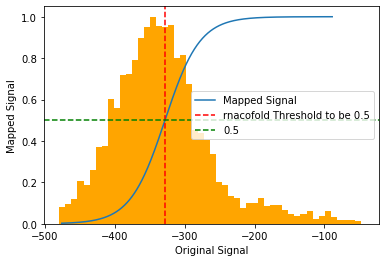

------- risearch2 -------


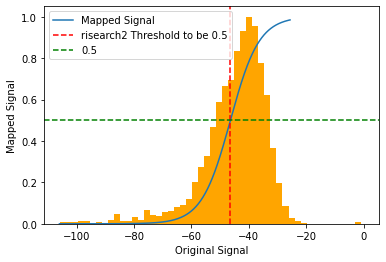

------- assa -------


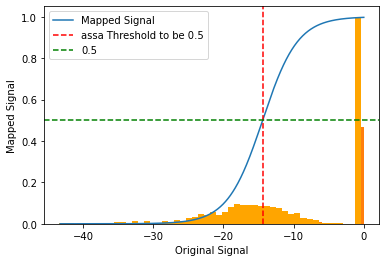

------- E_norm -------


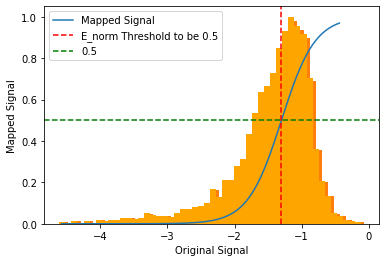

In [20]:
for tool_name in energy_columns:

    print(f'------- {tool_name} -------')
    treshold =  best_thresholds[tool_name]
    min_value_to_plot = res[tool_name].quantile(0.01)
    max_value_to_plot = res[tool_name].quantile(0.99)
    slope_at_origin = slope_at_the_origins[tool_name]

    # Example usage
    signal_range = np.linspace(min_value_to_plot, max_value_to_plot, 1000)


    mapped_signal = map_signal_to_sigmoid_range(signal_range,treshold, slope_at_origin = slope_at_origin)

    data_balanced = balance_df(res)
    data_balanced = data_balanced[data_balanced[tool_name]>min_value_to_plot].reset_index(drop = True)


    # Plotting the results
    plt.plot(signal_range, mapped_signal, label='Mapped Signal')
    plot_histogram_01(data_balanced[tool_name])

    #plt.hist(data_balanced[tool_name], density=True, bins=80) 
    plt.axvline(x=treshold, color='r', linestyle='--', label=f'{tool_name} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
    plt.xlabel('Original Signal')
    plt.ylabel('Mapped Signal')
    plt.legend()
    plt.show()